# Mini projekt PAD - scrapper danych o oponach
## Jakub Michalak S20034
### Opis projektu
- Projekt polega na pobraniu danych o oponach z dwóch sklepów internetowych: sklep opon i oponeo
- Opony są pobierane w rozmiarze 205/55R16 i sezonie zimowym
- Dane pobrane z obu sklepów zostaną zapisane w plikach CSV
- Dane zostaną oczyszczone i przygotowane do analizy

In [63]:
import pandas as pd
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException

# 1. Scrapping danych
### 1.1. Konfiguracja drivera do scrapowania danych 
- **Uwaga**: testowane na szerokości okna 1110 pikseli
- Ustawienie szerokości okna na 1100 pikseli pozwala na poprawne działanie skryptów do scrapowania danych ze stron sklep opon i oponeo. Przy wyższej szerokości okna mogą wystąpić problemy z lokalizacją elementów na stronie (np. oceny).

In [64]:
download_service = Service()
driver = webdriver.Chrome(service=download_service)
driver.set_window_size(1100, 800)

sklep_opon_base_url = "https://www.sklepopon.com/szukaj-opony?sezon=zimowe&rozmiar=205/55R16&ofs="
oponeo_base_url = "https://www.oponeo.pl/wybierz-opony/s=1/zimowe/t=1/osobowe/r=1/205-55-r16"

### 1.2. Funkcje obsługujące scrapowanie danych ze stron sklep opon i oponeo

In [65]:
def close_sklep_opon_popups(outer_driver):
    try:
        btn_cookie = outer_driver.find_element(By.CSS_SELECTOR, "#klaro > div > div > div > div > div > button")
        btn_cookie.click()
        print("Przycisk akceptacji ciasteczek został kliknięty.")
    except NoSuchElementException:
        print("Przycisk akceptacji ciasteczek nie został znaleziony.")
    except Exception as exception:
        print("Nie udało się kliknąć przycisku akceptacji ciasteczek:", exception)
    
    try:
        outer_driver.execute_script("""
            const shadowHost = document.querySelector("body > div.gr-visual-prompt");
            if (shadowHost) {
                const shadowRoot = shadowHost.shadowRoot;
                const closeButton = shadowRoot.querySelector("div > div:nth-child(2) > button:nth-child(1)");
                if (closeButton) {
                    closeButton.click();
                    console.log("Okienko powiadomień zostało zamknięte.");
                } else {
                    console.log("Nie znaleziono przycisku zamknięcia powiadomień.");
                }
            } else {
                console.log("Okno powiadomień nie zostało znalezione.");
            }
        """)
    except Exception as exception:
        print("Nie udało się zamknąć okienka powiadomień:", exception)

def close_oponeo_popup(outer_driver):
    try:
        reject_button = outer_driver.find_element(By.CSS_SELECTOR, "#consentsBar > div.buttonsContainer.container > div > span.reject")
        reject_button.click()
        print("Okienko prywatności zostało zamknięte.")
    except NoSuchElementException:
        print("Okienko prywatności nie jest widoczne lub zostało już zamknięte.")
    except Exception as e:
        print("Wystąpił błąd podczas zamykania okienka prywatności:", e)
        
def load_sklep_opon_tire_data(outer_driver):
    scrapped_data = []
    try:
        tire_elements = outer_driver.find_elements(By.CSS_SELECTOR, 'div[data-c-name="listing-products-element"]')
            
        class_mapping = {
            "Premium": "Premium",
            "Średnia": "Średnia",
            "Średniej": "Średnia",
            "Ekonomiczna": "Ekonomiczna",
            "Ekonomicznej": "Ekonomiczna"
        }
        
        for tire_element in tire_elements:
            
            try:
                load_index = tire_element.find_element(By.CSS_SELECTOR, 'li[data-attribute-code="li"]').text
                speed_index = tire_element.find_element(By.CSS_SELECTOR, 'li[data-attribute-code="si"]').text
            except NoSuchElementException:
                load_index = None
                speed_index = None
            
            noise_level = None
            try:
                noise_level_elements = tire_element.find_elements(By.CSS_SELECTOR, "span.self-center.tracking-tighter.sm\\:tracking-normal")
                for noise_level_element in noise_level_elements:
                    text = noise_level_element.text
                    match = re.search(r'\d+', text)
                    if match:
                        noise_level = int(match.group())
            except (NoSuchElementException, IndexError):
                pass
            
            etykieta_elements = tire_element.find_elements(By.CSS_SELECTOR, 'span.icon-fuel-new ~ span, span.icon-rain-new ~ span, span.icon-speaker-new ~ span')
            fuel_index = etykieta_elements[0].text if len(etykieta_elements) > 0 else None
            wet_grip_index = etykieta_elements[1].text if len(etykieta_elements) > 1 else None
            noise_index = etykieta_elements[2].text.split(" ")[0] if len(etykieta_elements) > 2 else None
            
            try:
                tire_class_element = tire_element.find_element(By.XPATH, ".//*[contains(translate(text(), 'ABCDEFGHIJKLMNOPQRSTUVWXYZ', 'abcdefghijklmnopqrstuvwxyz'), 'klas')]")
                tire_class_text = tire_class_element.text.lower().replace("w klasie ", "").replace("klasa ", "").strip().capitalize()
                tire_class = class_mapping.get(tire_class_text, tire_class_text)
            except NoSuchElementException:
                tire_class = None
                
            try:
                user_rating_element = tire_element.find_element(By.XPATH, ".//li[contains(@class, 'xl:hidden')]//span[contains(@class, 'ml-1')]")
                user_rating = float(user_rating_element.text.replace(",", "."))
            except NoSuchElementException:
                user_rating = None
                
            price = float(tire_element.get_attribute('data-ee-product-properties').split(";")[3].split(":")[1])
            
            try:
                availability_element = tire_element.find_element(By.CSS_SELECTOR, "div.tooltip-product-listing")
                availability_code = availability_element.get_attribute("data-attribute-code")
                
                if availability_code == "item_availability_tooltip_high":
                    availability = "full"
                elif availability_code == "item_availability_tooltip_medium":
                    availability = "medium"
                elif availability_code == "item_availability_tooltip_low":
                    availability = "low"
                elif availability_code == "item_availability_tooltip_last":
                    availability = "last"
                else:
                    availability = None
            except NoSuchElementException:
                availability = None
                
            tire_data = {
                "name": tire_element.get_attribute("data-ee-product-properties").split(";")[0].split(":")[1],
                "brand": tire_element.get_attribute("data-ee-product-properties").split(";")[4].split(":")[1],
                "model": tire_element.get_attribute("data-ee-product-properties").split(";")[6].split(":")[1],
                "size": tire_element.get_attribute("data-ee-product-properties").split(";")[5].split(":")[1],
                "load_index": load_index,
                "speed_index": speed_index,
                "fuel_index": fuel_index,
                "wet_grip_index": wet_grip_index,
                "noise_index": noise_index,
                "noise_level": noise_level,
                "class": tire_class,
                "user_rating": user_rating,
                "price": price,
                "availability": availability
            }
            
            scrapped_data.append(tire_data)
    finally:
        pass
    return scrapped_data   

def load_next_oponeo_page(web_driver, current_page_number):
    try:
        next_page_button = web_driver.find_element(By.ID, f"_ctPgrp_pi{current_page_number}i")
        next_page_button.click()
        time.sleep(2)
        return True
    except NoSuchElementException:
        return False
    
def load_oponeo_tire_data(outer_driver):
    scrapped_data = []
    tire_elements = outer_driver.find_elements(By.CLASS_NAME, "product")
    
    for tire_element in tire_elements:
        try:
            try:
                link_element = tire_element.find_element(By.CSS_SELECTOR, ".productName a")
                nazwa = link_element.get_attribute("title")
            except NoSuchElementException:
                nazwa = tire_element.find_element(By.CLASS_NAME, "productName").text

            noise = tire_element.find_element(By.CSS_SELECTOR, ".icon-noise em").text
            match = re.search(r'\d+', noise)
            if match:
                noise_level = int(match.group())
            else:
                noise_level = int(tire_element.find_element(By.CSS_SELECTOR, ".icon-noise em").text.split()[1].replace("dB", "").strip())
             
            noise_index = tire_element.find_element(By.CSS_SELECTOR, ".icon-noise em").text.split()[0] 
            noise_index_text = noise_index if noise_index in {"A", "B", "C", "D", "E", "F"} and len(noise_index) == 1 else None   
                
            try:
                user_rating = tire_element.find_element(By.CSS_SELECTOR, ".productRating .note").text
                user_rating = user_rating.replace(',', '.')
            except NoSuchElementException:
                user_rating = None
                
            try:
                stock_level_element = tire_element.find_element(By.CSS_SELECTOR, ".stockLevel")
                stock_level_class = stock_level_element.get_attribute("class").split()[-1]
                
                if stock_level_class == "full":
                    availability = "full"
                elif stock_level_class == "medium":
                    availability = "medium"
                elif stock_level_class == "low":
                    availability = "low"
                else:
                    availability = None
            except NoSuchElementException:
                availability = None
                
            tire_info = {
                "name": nazwa,
                "brand": tire_element.find_element(By.CLASS_NAME, "producerName").text,
                "model": tire_element.find_element(By.CLASS_NAME, "modelName").text,
                "size": tire_element.find_element(By.CLASS_NAME, "modelSize").text,
                "load_index": tire_element.find_element(By.XPATH, ".//span[@data-tp='TireLoadIndex']/em").text,
                "speed_index": tire_element.find_element(By.XPATH, ".//span[@data-tp='TireSpeedIndex']/em").text,
                "fuel_index": tire_element.find_element(By.CSS_SELECTOR, ".icon-fuel em").text,
                "wet_grip_index": tire_element.find_element(By.CSS_SELECTOR, ".icon-rain em").text,
                "noise_index": noise_index_text,
                "noise_level": noise_level,
                "class": tire_element.find_element(By.CLASS_NAME, "class").text.replace("KLASA ", "").capitalize(),
                "user_rating": user_rating,
                "price": tire_element.find_element(By.CLASS_NAME, "priceValue").text,
                "availability": availability
            }
            
            scrapped_data.append(tire_info)

        except NoSuchElementException:
            pass
            
    return scrapped_data   

def update_column_types(param_df):
    param_df['noise_level'] = pd.to_numeric(param_df['noise_level'], errors='coerce').astype('Int64')
    param_df['user_rating'] = pd.to_numeric(param_df['user_rating'], errors='coerce').astype(float)
    param_df['price'] = pd.to_numeric(param_df['price'], errors='coerce').astype(float)
    param_df['size'] = param_df['size'].astype('category')
    param_df['load_index'] = param_df['load_index'].astype('category')
    param_df['speed_index'] = param_df['speed_index'].astype('category')
    param_df['fuel_index'] = param_df['fuel_index'].astype('category')
    param_df['wet_grip_index'] = param_df['wet_grip_index'].astype('category')
    param_df['noise_index'] = param_df['noise_index'].astype('category')
    param_df['class'] = param_df['class'].astype('category')
    param_df['availability'] = param_df['availability'].astype('category')
    param_df['user_rating'] = param_df['user_rating'].astype('float32')
    param_df['price'] = param_df['price'].astype('float32')

### 1.3. Kod do pobierania danych ze strony sklep opon

In [66]:
sklep_opon_tires_data = []
offset = 0

while True:
    url = f"{sklep_opon_base_url}{offset}"
    driver.get(url)
    time.sleep(4)
    
    if offset == 0:
        close_sklep_opon_popups(driver)
    
    tires_data = load_sklep_opon_tire_data(driver)
    sklep_opon_tires_data.extend(tires_data)
    
    offset += 20
    if len(driver.find_elements(By.CSS_SELECTOR, 'div[data-c-name="listing-products-element"]')) == 0:
        print("Brak nowych danych. Koniec paginacji.")
        break

df_sklep_opon = pd.DataFrame(sklep_opon_tires_data)
display(df_sklep_opon)

Przycisk akceptacji ciasteczek został kliknięty.
Brak nowych danych. Koniec paginacji.


,name,brand,model,size,load_index,speed_index,fuel_index,wet_grip_index,noise_index,noise_level,class,user_rating,price,availability
0,Wintrac 205/55 R16 91 H,Vredestein,Wintrac,205/55 R16,91,H,C,B,B,70.0,Premium,5.4,376.99,full
1,WinterExpert 205/55 R16 91 T,Uniroyal,WinterExpert,205/55 R16,91,T,C,B,B,71.0,Średnia,5.4,343.99,full
2,SP901 205/55 R16 91 H,Austone,SP901,205/55 R16,91,H,D,D,B,72.0,Ekonomiczna,5.1,229.99,full
3,Frigo 2 205/55 R16 91 T,Dębica,Frigo 2,205/55 R16,91,T,C,C,B,71.0,Ekonomiczna,5.1,249.00,full
4,Winter i*cept RS3 W462 205/55 R16 91 T,Hankook,Winter i*cept RS3 W462,205/55 R16,91,T,C,B,B,72.0,Premium,5.3,322.00,full
5,Frigo HP2 205/55 R16 91 H,Dębica,Frigo HP2,205/55 R16,91,H,C,C,B,72.0,Ekonomiczna,5.2,299.00,full
6,Z507 205/55 R16 91 V,Goodride,Z507,205/55 R16,91,V,C,C,B,72.0,Ekonomiczna,5.1,239.99,full
7,SW608 205/55 R16 91 H,Goodride,SW608,205/55 R16,91,H,C,C,B,72.0,Ekonomiczna,5.1,249.99,full
8,Polaris 6 205/55 R16 91 T,Barum,Polaris 6,205/55 R16,91,T,B,C,B,72.0,Ekonomiczna,5.0,319.00,full
9,WinterExpert 205/55 R16 91 H,Uniroyal,WinterExpert,205/55 R16,91,H,C,B,B,71.0,Średnia,5.4,350.00,full


### 1.4. Kod do pobierania danych ze strony oponeo

In [67]:
driver.get(oponeo_base_url)
close_oponeo_popup(driver)

all_tires_data = []

page_number = 1
while True:
    tires_data = load_oponeo_tire_data(driver)
    all_tires_data.extend(tires_data)
    
    page_number += 1
    if not load_next_oponeo_page(driver, page_number):
        print("Brak nowych danych. Koniec paginacji.")
        break

df_oponeo = pd.DataFrame(all_tires_data)
display(df_oponeo)

Okienko prywatności zostało zamknięte.
Brak nowych danych. Koniec paginacji.


,name,brand,model,size,load_index,speed_index,fuel_index,wet_grip_index,noise_index,noise_level,class,user_rating,price,availability
0,Bridgestone Blizzak LM005 205/55 R16 91 H,Bridgestone,Blizzak LM005,205/55 R16,91,H,C,A,B,71,Premium,4.7,469,full
1,Michelin Alpin 7 205/55 R16 91 T,Michelin,Alpin 7,205/55 R16,91,T,C,B,B,71,Premium,4.8,461,full
2,Neolin NeoWinter 205/55 R16 94 V XL,Neolin,NeoWinter,205/55 R16,94,V,D,D,B,71,Ekonomiczna,4.4,224,full
3,Imperial Snowdragon HP 205/55 R16 91 V,Imperial,Snowdragon HP,205/55 R16,91,V,C,C,B,70,Ekonomiczna,4.3,216,full
4,Compasal WinterBlazer HP 205/55 R16 91 H,Compasal,WinterBlazer HP,205/55 R16,91,H,D,C,B,72,Ekonomiczna,None,197,full
5,Neolin NeoWinter 205/55 R16 91 V,Neolin,NeoWinter,205/55 R16,91,V,D,D,B,71,Ekonomiczna,4.4,199,full
6,Firemax FM805+ 205/55 R16 91 H,Firemax,FM805+,205/55 R16,91,H,D,C,A,67,Ekonomiczna,4.4,214,full
7,Imperial Snowdragon UHP 205/55 R16 91 H,Imperial,Snowdragon UHP,205/55 R16,91,H,C,C,B,72,Ekonomiczna,4.3,215,full
8,Imperial Snowdragon HP 205/55 R16 91 H,Imperial,Snowdragon HP,205/55 R16,91,H,C,C,B,70,Ekonomiczna,4.3,217,full
9,Imperial Snowdragon UHP 205/55 R16 94 H XL,Imperial,Snowdragon UHP,205/55 R16,94,H,C,C,B,72,Ekonomiczna,4.3,220,full


### 1.5. Zamknięcie drivera po scrapowaniu danych

In [68]:
driver.quit()

### 1.6. Zapisanie danych do plików CSV
- służy to do zapisania danych do plików CSV, aby można było je łatwo odtworzyć w przyszłości
- dane zapisane w plikach CSV można wczytać do DataFrame za pomocą funkcji `pd.read_csv`

In [69]:
df_sklep_opon.to_csv("data/miniprojekt/sklep_opon.csv", index=False)
df_oponeo.to_csv("data/miniprojekt/oponeo.csv", index=False)
df_sklep_opon = pd.read_csv("data/miniprojekt/sklep_opon.csv", delimiter=",")
df_oponeo = pd.read_csv("data/miniprojekt/oponeo.csv", delimiter=",")

### 1.7. Weryfikacja poprawnych wartości w każdej kolumnie

In [70]:
print("sklep opon")
print("typy danych w kolumnach")
print(df_sklep_opon.dtypes)
print("unikalne wartości w kolumnach")
for column in df_sklep_opon.columns:
    if column not in ["name", "brand", "model"]:
        print(column, df_sklep_opon[column].unique())
print("oponeo")
print("typy danych w kolumnach")
print(df_oponeo.dtypes)
print("unikalne wartości w kolumnach")
for column in df_oponeo.columns:
    if column not in ["name", "brand", "model"]:
        print(column, df_oponeo[column].unique())

sklep opon
typy danych w kolumnach
name               object
brand              object
model              object
size               object
load_index          int64
speed_index        object
fuel_index         object
wet_grip_index     object
noise_index        object
noise_level       float64
class              object
user_rating       float64
price             float64
availability       object
dtype: object
unikalne wartości w kolumnach
size ['205/55 R16']
load_index [91 94]
speed_index ['H' 'T' 'V' 'R']
fuel_index ['C' 'D' 'B' nan 'E']
wet_grip_index ['B' 'D' 'C' 'A' nan 'E']
noise_index ['B' 'A' nan 'C']
noise_level [70. 71. 72. 69. nan 67. 68.]
class ['Premium' 'Średnia' 'Ekonomiczna' nan]
user_rating [5.4 5.1 5.3 5.2 5.  5.5 5.6 nan 6.  4.3 4.4 1.  4.9 4.8 4.6 4.7 2.3 4.5
 4.2 5.8 1.4 5.7 2.5]
price [ 376.99  343.99  229.99  249.    322.    299.    239.99  249.99  319.
  350.    320.    344.    399.    455.    310.    435.    284.12  402.99
  380.    289.99  355.    387.86  347. 

# 2. Czyszczenie i przygotowanie danych

### 2.1. konwersja kolumn do typów numerycznych i typu category

In [71]:
update_column_types(df_oponeo)
update_column_types(df_sklep_opon)

### 2.2. Funkcje pomocnicze

In [72]:
def find_closest_key(value, param_map):
        closest_key = min(param_map, key=lambda k: abs(param_map[k] - value))
        return closest_key

def find_closest_value(value, param_map):
        closest_key = min(param_map, key=lambda k: abs(param_map[k] - value))
        return param_map[closest_key]

### 2.3. Uzupełnianie noise_index na podstawie noise_level

In [74]:
def update_noise_index_column(df):
    grouped_noise_index = df.groupby('noise_index', observed=False)['noise_level'].mean().round().astype(int)
    
    if 'C' not in grouped_noise_index:
        if 'B' in grouped_noise_index and 'A' in grouped_noise_index:
            grouped_noise_index['C'] = grouped_noise_index['B'] + (grouped_noise_index['B'] - grouped_noise_index['A'])
    
    noise_map = grouped_noise_index.to_dict()
    
    def apply_update_noise_index(row):
        if pd.notna(row['noise_level']) and pd.isna(row['noise_index']):
            return find_closest_key(row['noise_level'], noise_map)
        return row['noise_index']
    
    df['noise_index'] = df.apply(apply_update_noise_index, axis=1)
    
    return df

df_oponeo = update_noise_index_column(df_oponeo)
df_sklep_opon = update_noise_index_column(df_sklep_opon)

print("Zaktualizowano noise_index")
print(df_oponeo['noise_index'].unique())
print(df_sklep_opon['noise_index'].unique())

Zaktualizowano noise_index
['B' 'A' 'C']
['B' 'A' nan 'C']


### 2.4. Uzupełnianie ceny na podstawie średniej ceny i klasy na podstawie ceny

In [76]:
def update_price_column(param_df):
    class_price_map = param_df.groupby('class', observed=False)['price'].mean().to_dict()
    
    def apply_update_price(row):
        if pd.isna(row['price']):
            return find_closest_value(row['price'], class_price_map)
        return row['price']
    
    def apply_update_class(row):
        if pd.isna(row['class']):
            return find_closest_key(row['price'], class_price_map)
        return row['class']
    
    param_df['price'] = param_df.apply(apply_update_price, axis=1)
    param_df['class'] = param_df.apply(apply_update_class, axis=1)
    
    return param_df

df_oponeo = update_price_column(df_oponeo)
df_sklep_opon = update_price_column(df_sklep_opon)

print("Zaktualizowano cenę i klasę")
print("oponeo")
print(df_oponeo['price'].unique())
print(df_oponeo['class'].unique())
print("sklep opon")
print(df_sklep_opon['price'].unique())
print(df_sklep_opon['class'].unique())

Zaktualizowano cenę i klasę
oponeo
[469. 461. 224. 216. 197. 199. 214. 215. 217. 220. 229. 249. 254. 269.
 272. 274. 279. 294. 295. 307. 309. 329. 337. 343. 344. 347. 349. 354.
 357. 363. 369. 384. 387. 396. 397. 398. 399. 417. 427. 434. 442. 447.
 454. 467. 468. 472. 534. 589. 218. 230. 257. 261. 264. 267. 268. 270.
 276. 277. 283. 284. 286. 289. 290. 292. 296. 297. 298. 301. 304. 305.
 308. 311. 313. 314. 317. 321. 326. 332. 334. 339. 342. 345. 348. 355.
 356. 359. 360. 365. 366. 372. 373. 375. 377. 378. 380. 381. 385. 391.
 393. 403. 404. 408. 409. 410. 412. 416. 419. 424. 437. 438. 439. 440.
 443. 446. 448. 450. 451. 453. 455. 460. 465. 470. 473. 474. 477. 481.
 496. 505. 506. 509. 511. 513. 521. 522. 525. 527. 533. 535. 549. 553.
 554. 558. 560. 562. 565. 572. 576. 579. 582. 585. 593. 606. 629. 632.
 638. 649. 660. 682. 692. 695. 704. 729. 905. 906.]
['Premium' 'Ekonomiczna' 'Średnia']
sklep opon
[ 376.98999023  343.98999023  229.99000549  249.          322.
  299.          239.99

### 2.5. Znalezienie, uzupełnienie i usunięcie duplikatów
- Funkcja do identyfikacji duplikatów na podstawie 'name', 'brand', 'model' i wypełniania brakujących danych
- Usuwa duplikaty na podstawie ilości uzupełnionych kolumn - zostawia wiersz z największą ilością uzupełnionych kolumn

In [77]:
def fill_missing_with_duplicates(df_param):
    duplicates = df_param[df_param.duplicated(subset=['name', 'brand', 'model'], keep=False)]
    
    for idx, group in duplicates.groupby(['name', 'brand', 'model']):
        for col in df_param.columns:
            if group[col].isna().any():
                # Jeśli mamy wartości do wypełnienia, to szukamy pierwszej dostępnej wartości
                fill_value = group[col].dropna().iloc[0] if not group[col].dropna().empty else None
                if fill_value is not None:  # Tylko wypełniaj, jeśli fill_value nie jest None
                    df_param.loc[group.index, col] = df_param.loc[group.index, col].fillna(fill_value)

    df_param['non_nan_count'] = df_param.notna().sum(axis=1)
    df_param = df_param.loc[df_param.groupby(['name', 'brand', 'model'])['non_nan_count'].idxmax()]
    df_param.drop(columns=['non_nan_count'], inplace=True)
    
    return df_param

print("Przed usunięciem duplikatów")
print(df_oponeo.shape)
print(df_sklep_opon.shape)

df_oponeo = fill_missing_with_duplicates(df_oponeo)
df_sklep_opon = fill_missing_with_duplicates(df_sklep_opon)

print("Po usunięciu duplikatów")
print(df_oponeo.shape)
print(df_sklep_opon.shape)

Przed usunięciem duplikatów
(220, 14)
(415, 14)
Po usunięciu duplikatów
(206, 14)
(290, 14)


### 2.6. Usuwanie wierszy z brakującymi wartościami w istotnych kolumnach

In [78]:
df_oponeo.dropna(subset=['fuel_index', 'wet_grip_index', 'noise_index'], inplace=True)
df_sklep_opon.dropna(subset=['fuel_index', 'wet_grip_index', 'noise_index'], inplace=True)

df_oponeo.dropna(subset=['availability'], inplace=True)
df_sklep_opon.dropna(subset=['availability'], inplace=True)

print("Po usunięciu braków danych")
print(df_oponeo.shape)
print(df_sklep_opon.shape)

Po usunięciu braków danych
(194, 14)
(218, 14)


### 2.7. Zastąpienie brakujących wartości w user_rating na 0

In [79]:
df_oponeo['user_rating'] = df_oponeo['user_rating'].fillna(0)
df_sklep_opon['user_rating'] = df_sklep_opon['user_rating'].fillna(0)

### 2.8. Wyświetlenie danych po czyszczeniu i zapisanie do plików CSV

In [80]:
print("sklep opon")
print("typy danych w kolumnach")
print(df_sklep_opon.dtypes)
print("unikalne wartości w kolumnach")
for column in df_sklep_opon.columns:
    if column not in ["name", "brand", "model"]:
        print(column, df_sklep_opon[column].unique())
display(df_sklep_opon)

print("oponeo")
print("typy danych w kolumnach")
print(df_oponeo.dtypes)
print("unikalne wartości w kolumnach")
for column in df_oponeo.columns:
    if column not in ["name", "brand", "model"]:
        print(column, df_oponeo[column].unique())
display(df_oponeo)

df_oponeo.to_csv("data/miniprojekt/oponeo_cleaned.csv", index=False)
df_sklep_opon.to_csv("data/miniprojekt/sklep_opon_cleaned.csv", index=False)

sklep opon
typy danych w kolumnach
name                object
brand               object
model               object
size              category
load_index        category
speed_index       category
fuel_index        category
wet_grip_index    category
noise_index         object
noise_level          Int64
class               object
user_rating        float32
price              float64
availability      category
dtype: object
unikalne wartości w kolumnach
size ['205/55 R16']
Categories (1, object): ['205/55 R16']
load_index [91, 94]
Categories (2, int64): [91, 94]
speed_index ['H', 'T', 'V', 'R']
Categories (4, object): ['H', 'R', 'T', 'V']
fuel_index ['D', 'C', 'E', 'B']
Categories (4, object): ['B', 'C', 'D', 'E']
wet_grip_index ['B', 'A', 'C', 'D', 'E']
Categories (5, object): ['A', 'B', 'C', 'D', 'E']
noise_index ['A' 'B' 'C']
noise_level <IntegerArray>
[68, 69, 71, 70, 72, 67]
Length: 6, dtype: Int64
class ['Premium' 'Średnia' 'Ekonomiczna']
user_rating [5.5 5.7 5.1 5.3 4.6 5.2 5.  5

,name,brand,model,size,load_index,speed_index,fuel_index,wet_grip_index,noise_index,noise_level,class,user_rating,price,availability
63,Alpin 5 205/55 R16 91 H,Michelin,Alpin 5,205/55 R16,91,H,D,B,A,68,Premium,5.5,737.719971,full
310,Alpin 6 205/55 R16 91 H,Michelin,Alpin 6,205/55 R16,91,H,C,B,A,69,Premium,5.7,1165.630005,medium
280,Alpin 6 205/55 R16 91 T,Michelin,Alpin 6,205/55 R16,91,T,C,B,A,69,Premium,5.7,826.820007,full
27,Alpin 7 205/55 R16 91 H,Michelin,Alpin 7,205/55 R16,91,H,C,B,B,71,Premium,5.5,465.000000,full
26,Alpin 7 205/55 R16 91 T,Michelin,Alpin 7,205/55 R16,91,T,C,B,B,71,Premium,5.5,460.000000,full
103,Alpin 7 205/55 R16 94 H,Michelin,Alpin 7,205/55 R16,94,H,C,B,B,71,Premium,5.5,544.880005,full
55,Blizzak 6 205/55 R16 91 H,Bridgestone,Blizzak 6,205/55 R16,91,H,C,B,B,70,Premium,5.1,445.519989,full
97,Blizzak LM001 205/55 R16 91 H,Bridgestone,Blizzak LM001,205/55 R16,91,H,D,B,B,72,Premium,5.3,553.729980,medium
110,Blizzak LM001 EVO 205/55 R16 91 H,Bridgestone,Blizzak LM001 EVO,205/55 R16,91,H,C,B,B,72,Premium,4.6,464.459991,full
13,Blizzak LM005 205/55 R16 91 H,Bridgestone,Blizzak LM005,205/55 R16,91,H,C,A,B,71,Premium,5.5,455.000000,full


oponeo
typy danych w kolumnach
name                object
brand               object
model               object
size              category
load_index        category
speed_index       category
fuel_index        category
wet_grip_index    category
noise_index         object
noise_level          Int64
class               object
user_rating        float32
price              float64
availability      category
dtype: object
unikalne wartości w kolumnach
size ['205/55 R16']
Categories (1, object): ['205/55 R16']
load_index [91, 94]
Categories (2, int64): [91, 94]
speed_index ['H', 'T', 'V']
Categories (3, object): ['H', 'T', 'V']
fuel_index ['D', 'C', 'B', 'E', 'F']
Categories (5, object): ['B', 'C', 'D', 'E', 'F']
wet_grip_index ['C', 'E', 'D', 'B', 'A', 'F']
Categories (6, object): ['A', 'B', 'C', 'D', 'E', 'F']
noise_index ['B' 'A' 'C']
noise_level <IntegerArray>
[72, 71, 69, 70, 68, 67, 73]
Length: 7, dtype: Int64
class ['Ekonomiczna' 'Średnia' 'Premium']
user_rating [5.  4.4 0.  4.5 4.7

,name,brand,model,size,load_index,speed_index,fuel_index,wet_grip_index,noise_index,noise_level,class,user_rating,price,availability
66,Aplus A701 205/55 R16 91 H,Aplus,A701,205/55 R16,91,H,D,C,B,72,Ekonomiczna,5.0,284.0,full
119,Apollo Alnac 4G Winter 205/55 R16 91 H,Apollo,Alnac 4G Winter,205/55 R16,91,H,C,C,B,71,Ekonomiczna,4.4,375.0,medium
117,Apollo Alnac 4G Winter 205/55 R16 91 T,Apollo,Alnac 4G Winter,205/55 R16,91,T,C,C,B,71,Ekonomiczna,4.4,373.0,full
139,Apollo Alnac 4G Winter 205/55 R16 94 H XL,Apollo,Alnac 4G Winter,205/55 R16,94,H,D,C,B,71,Ekonomiczna,4.4,412.0,full
81,Arivo Winmaster ARW 1 205/55 R16 91 H,Arivo,Winmaster ARW 1,205/55 R16,91,H,C,E,A,69,Ekonomiczna,0.0,297.0,full
166,Arivo Winmaster ARW 2 205/55 R16 91 H,Arivo,Winmaster ARW 2,205/55 R16,91,H,C,C,B,70,Ekonomiczna,4.5,460.0,full
58,Atlas Tires Polarbear UHP 205/55 R16 91 V,Atlas Tires,Polarbear UHP,205/55 R16,91,V,C,D,A,68,Ekonomiczna,4.4,274.0,full
100,Austone SP901 205/55 R16 91 H,Austone,SP901,205/55 R16,91,H,D,D,B,72,Ekonomiczna,4.5,334.0,full
49,Autogreen Snow Chaser 2 AW08 205/55 R16 91 H,Autogreen,Snow Chaser 2 AW08,205/55 R16,91,H,D,C,B,72,Ekonomiczna,0.0,230.0,full
185,BFGoodrich G-Force Winter 2 205/55 R16 91 H,BFGoodrich,G-Force Winter 2,205/55 R16,91,H,D,B,A,69,Średnia,4.4,513.0,medium


# 3. Eksploracyjna Analiza danych

- Opcjonalne ładowanie oczyszczonych danych z plików CSV jeżeli nie chcemy ponownie scrapować danych

In [81]:
df_oponeo = pd.read_csv("data/miniprojekt/oponeo_cleaned.csv", delimiter=",")
df_sklep_opon = pd.read_csv("data/miniprojekt/sklep_opon_cleaned.csv", delimiter=",")
update_column_types(df_oponeo)
update_column_types(df_sklep_opon)

df_oponeo['retailer'] = 'Oponeo'
df_sklep_opon['retailer'] = 'Sklep opon'
df = pd.concat([df_oponeo, df_sklep_opon], ignore_index=True)

### 3.1. Średnia, mediana, min i max cen opon w każdym sklepie

In [82]:
price_stats = df.groupby('retailer')['price'].agg(['mean', 'median', 'min', 'max'])
price_stats

,mean,median,min,max
retailer,,,,
Oponeo,403.639160,389.000000,197.000000,906.000000
Sklep opon,483.473602,431.630005,197.089996,5339.299805


### 3.2. Średnia cena opon w zależności od marki i sklepu

In [83]:
brand_price_stats = df.groupby(['retailer', 'brand'])['price'].mean().unstack()
brand_price_stats

brand,Aplus,Apollo,Arivo,Atlas Tires,Austone,Autogreen,BFGoodrich,Barum,Bfgoodrich,Bridgestone,...,Triangle,Tristar,Uniroyal,Viking,Vredestein,West Lake,Windforce,Yokohama,ZMax,Zeetex
retailer,,,,,,,,,,,,,,,,,,,,,
Oponeo,284.0,386.666656,378.500000,274.0,334.000000,230.00000,541.666687,404.666656,NaN,522.00000,...,308.000000,290.0,452.0000,470.000000,428.333344,376.5,326.000000,440.750000,NaN,269.0
Sklep opon,NaN,NaN,303.535004,NaN,279.380005,324.01001,NaN,505.124298,594.057495,568.48999,...,260.579987,NaN,414.5625,503.470001,423.454010,NaN,403.112488,390.790009,439.549988,NaN


### 3.3. Średnia cena opon w zależności od klasy i sklepu

In [84]:
class_price_stats = df.groupby(['retailer', 'class'], observed=False)['price'].mean().unstack()
class_price_stats

class,Ekonomiczna,Premium,Średnia
retailer,,,
Oponeo,330.871277,523.944458,425.512817
Sklep opon,332.562317,642.035767,441.840454


### 3.4. Liczba opon w każdej klasie efektywności w obu sklepach

In [85]:
class_distribution = df.groupby(['retailer', 'class'], observed=False).size().unstack()
class_distribution

class,Ekonomiczna,Premium,Średnia
retailer,,,
Oponeo,101,54,39
Sklep opon,69,83,66


### 3.5. Średnia ceny opon w zależności od:
 - sklepu oraz indeksów: paliwowego, przyczepności i hałasu
 - sklepu oraz nośności
 - sklepu oraz indeksu prędkości

In [86]:
pivot_price_indices = df.pivot_table(
    values='price',
    index='retailer',
    columns=['fuel_index', 'wet_grip_index', 'noise_index'],
    aggfunc='mean',
    observed=False
)
display(pivot_price_indices)

pivot_price_speed_load = df.pivot_table(
    values='price',
    index='retailer',
    columns='speed_index',
    aggfunc='mean',
    observed=False
)
display(pivot_price_speed_load)

pivot_price_load = df.pivot_table(
    values='price',
    index='retailer',
    columns='load_index',
    aggfunc='mean',
    observed=False
)
display(pivot_price_load)

fuel_index          B                                  C              \
wet_grip_index      B           C          D           A           B   
noise_index         A           B          A           B           A   
retailer                                                               
Oponeo          511.0  386.399994        NaN  525.333313  468.750000   
Sklep opon      435.0  398.709991  641.02002  616.841980  563.728455   

fuel_index                                                    ...          D  \
wet_grip_index                   C                         D  ...          D   
noise_index              B       A           B      C      A  ...          B   
retailer                                                      ...              
Oponeo          436.826080  483.75  355.500000  317.0  269.0  ...  301.00000   
Sklep opon      468.983368     NaN  404.236359    NaN    NaN  ...  584.58429   

fuel_index                      E                                        \
wet_grip_index           E      B                  C                  D   
noise_index              B      A           B      A           B      B   
retailer                                                                  
Oponeo                 NaN  729.0  326.000000  905.0  377.142853  290.0   
Sklep opon      386.519989    NaN  405.744995    NaN  449.428345    NaN   

fuel_index                             F  
wet_grip_index           E      F      C  
noise_index              B      B      B  
retailer                                  
Oponeo          375.000000  363.0  335.5  
Sklep opon      597.210022    NaN    NaN  

[2 rows x 29 columns]

speed_index,H,R,T,V
retailer,,,,
Oponeo,401.225800,NaN,423.000000,392.828583
Sklep opon,439.407959,641.02002,543.550964,547.037170


load_index,91,94
retailer,,
Oponeo,401.835815,407.666656
Sklep opon,467.818207,511.572968


### 3.6. Porównanie:
 - cen opon w obu sklepach dla tych samych modeli
  - dostępności opon w obu sklepach dla tych samych modeli
  - ocen użytkowników opon w obu sklepach dla tych samych modeli

In [87]:
#pd.options.display.max_rows = 10
pd.options.display.max_rows = None

unique_df_price = df.groupby(['brand', 'model', 'retailer'], as_index=False)['price'].min()

df_oponeo = unique_df_price[unique_df_price['retailer'] == 'Oponeo'][['brand', 'model', 'price']].rename(columns={'price': 'Oponeo'})
df_sklep_opon = unique_df_price[unique_df_price['retailer'] == 'Sklep opon'][['brand', 'model', 'price']].rename(columns={'price': 'Sklep opon'})

price_comparison_df = pd.merge(df_oponeo, df_sklep_opon, on=['brand', 'model'], how='inner')

price_comparison_df['cheaper_in'] = price_comparison_df.apply(
    lambda row: 'Oponeo' if row['Oponeo'] < row['Sklep opon'] else 'Sklep opon' if row['Oponeo'] > row['Sklep opon'] else 'Same price',
    axis=1
)
display(price_comparison_df)

unique_df_availability = df.groupby(['brand', 'model', 'retailer'], as_index=False)['availability'].max()

df_oponeo = unique_df_availability[unique_df_availability['retailer'] == 'Oponeo'][['brand', 'model', 'availability']].rename(columns={'availability': 'Oponeo'})
df_sklep_opon = unique_df_availability[unique_df_availability['retailer'] == 'Sklep opon'][['brand', 'model', 'availability']].rename(columns={'availability': 'Sklep opon'})

availability_comparison_df = pd.merge(df_oponeo, df_sklep_opon, on=['brand', 'model'], how='inner')

availability_comparison_df['more_available_in'] = availability_comparison_df.apply(
    lambda row: 'Oponeo' if row['Oponeo'] > row['Sklep opon'] else 'Sklep opon' if row['Oponeo'] < row['Sklep opon'] else 'Taka sama dostępność',
    axis=1
)
display(availability_comparison_df)

unique_df_ratings = df.groupby(['brand', 'model', 'retailer'], as_index=False)['user_rating'].max()

df_oponeo = unique_df_ratings[unique_df_ratings['retailer'] == 'Oponeo'][['brand', 'model', 'user_rating']].rename(columns={'user_rating': 'Oponeo'})
df_sklep_opon = unique_df_ratings[unique_df_ratings['retailer'] == 'Sklep opon'][['brand', 'model', 'user_rating']].rename(columns={'user_rating': 'Sklep opon'})

rating_comparison_df = pd.merge(df_oponeo, df_sklep_opon, on=['brand', 'model'], how='inner')

rating_comparison_df['higher_rating_in'] = rating_comparison_df.apply(
    lambda row: 'Oponeo' if row['Oponeo'] > row['Sklep opon'] else 'Sklep opon' if row['Oponeo'] < row['Sklep opon'] else 'Taka sama ocena',
    axis=1
)
display(rating_comparison_df)


,brand,model,Oponeo,Sklep opon,cheaper_in
0,Arivo,Winmaster ARW 2,460.0,237.710007,Sklep opon
1,Austone,SP901,334.0,229.990005,Sklep opon
2,Autogreen,Snow Chaser 2 AW08,230.0,324.010010,Oponeo
3,Barum,Polaris 6,355.0,319.000000,Sklep opon
4,Bridgestone,Blizzak 6,437.0,445.519989,Oponeo
5,Bridgestone,Blizzak LM001,505.0,553.729980,Oponeo
6,Bridgestone,Blizzak LM001 EVO,448.0,464.459991,Oponeo
7,Bridgestone,Blizzak LM005,469.0,455.000000,Sklep opon
8,Continental,WinterContact TS 860 S,572.0,573.049988,Oponeo
9,Continental,WinterContact TS 870,477.0,476.989990,Sklep opon


,brand,model,Oponeo,Sklep opon,more_available_in
0,Arivo,Winmaster ARW 2,full,full,Taka sama dostępność
1,Austone,SP901,full,full,Taka sama dostępność
2,Autogreen,Snow Chaser 2 AW08,full,full,Taka sama dostępność
3,Barum,Polaris 6,medium,low,Oponeo
4,Bridgestone,Blizzak 6,full,full,Taka sama dostępność
5,Bridgestone,Blizzak LM001,low,medium,Sklep opon
6,Bridgestone,Blizzak LM001 EVO,full,full,Taka sama dostępność
7,Bridgestone,Blizzak LM005,full,medium,Sklep opon
8,Continental,WinterContact TS 860 S,medium,full,Oponeo
9,Continental,WinterContact TS 870,full,full,Taka sama dostępność


,brand,model,Oponeo,Sklep opon,higher_rating_in
0,Arivo,Winmaster ARW 2,4.5,5.6,Sklep opon
1,Austone,SP901,4.5,5.1,Sklep opon
2,Autogreen,Snow Chaser 2 AW08,0.0,0.0,Taka sama ocena
3,Barum,Polaris 6,5.0,5.0,Taka sama ocena
4,Bridgestone,Blizzak 6,0.0,5.1,Sklep opon
5,Bridgestone,Blizzak LM001,4.4,5.3,Sklep opon
6,Bridgestone,Blizzak LM001 EVO,4.5,4.6,Sklep opon
7,Bridgestone,Blizzak LM005,4.7,5.5,Sklep opon
8,Continental,WinterContact TS 860 S,4.6,5.6,Sklep opon
9,Continental,WinterContact TS 870,4.8,5.6,Sklep opon


# 4. Wizualizacja danych

### 4.1. Średnia cena:
- w zależności od sklepu
- w zależności od marki i sklepu

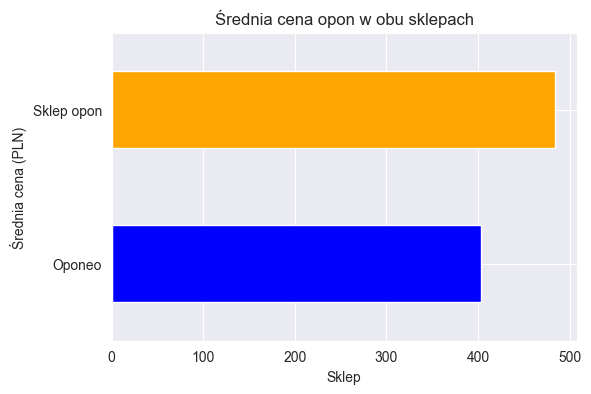

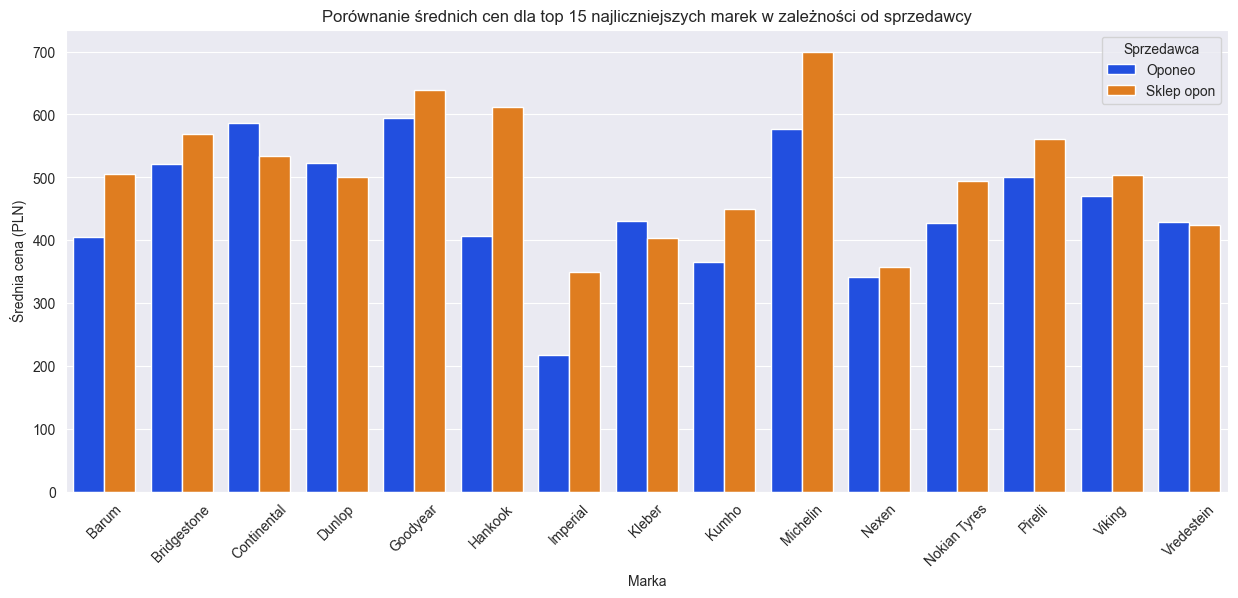

In [88]:
avg_price_by_source = df.groupby('retailer')['price'].mean()
plt.figure(figsize=(6, 4))
avg_price_by_source.plot(kind='barh', color=['blue', 'orange'])
plt.title("Średnia cena opon w obu sklepach")
plt.ylabel("Średnia cena (PLN)")
plt.xlabel("Sklep")
plt.show()

top_15_brands = df['brand'].value_counts().nlargest(15).index
df_top_brands = df[df['brand'].isin(top_15_brands)]
avg_price_by_brand_retailer = df_top_brands.groupby(['brand', 'retailer'])['price'].mean().reset_index()
plt.figure(figsize=(15, 6))
# custom_hex_palette = sns.color_palette(["#66b3ff", "#99ff99"])
# sns.barplot(x='brand', y='price', hue='retailer', data=avg_price_by_brand_retailer, palette=custom_hex_palette)
sns.barplot(x='brand', y='price', hue='retailer', data=avg_price_by_brand_retailer, palette="bright")
plt.title("Porównanie średnich cen dla top 15 najliczniejszych marek w zależności od sprzedawcy")
plt.xlabel("Marka")
plt.ylabel("Średnia cena (PLN)")
plt.xticks(rotation=45)
plt.legend(title="Sprzedawca")
plt.show()

### 4.2. Rozkład:
- indeksu efektywności paliwowej w zależności od sklepu
- indeksu przyczepności na mokrej nawierzchni w zależności od sklepu
- poziomu hałasu w zależności od sklepu
- klas opon w zależności od sklepu

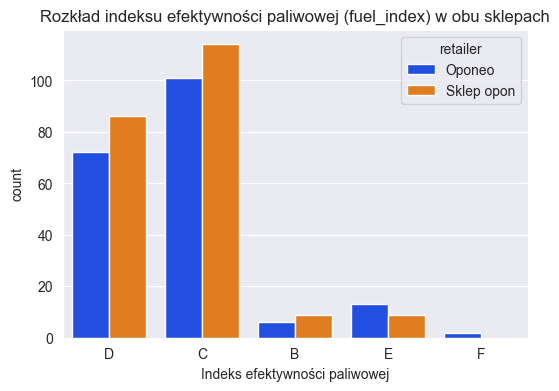

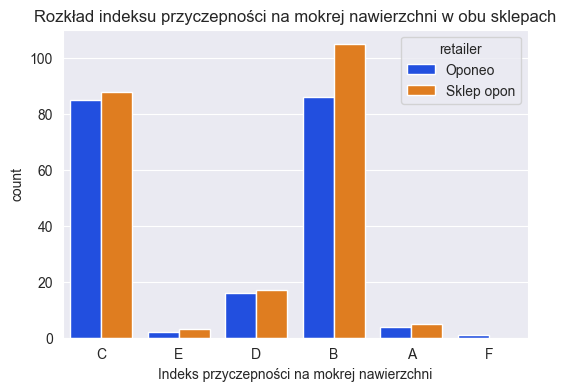

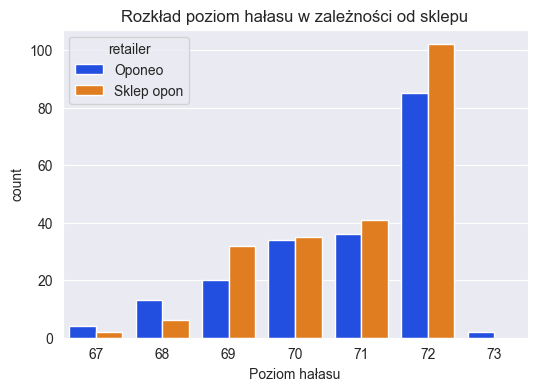

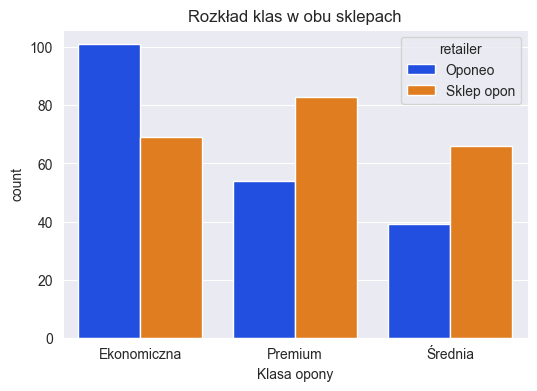

In [89]:
plt.figure(figsize=(6, 4))
sns.countplot(x='fuel_index', hue='retailer', data=df, palette='bright')
plt.title("Rozkład indeksu efektywności paliwowej (fuel_index) w obu sklepach")
plt.xlabel("Indeks efektywności paliwowej")
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x='wet_grip_index', hue='retailer', data=df, palette='bright')
plt.title("Rozkład indeksu przyczepności na mokrej nawierzchni w obu sklepach")
plt.xlabel("Indeks przyczepności na mokrej nawierzchni")
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x='noise_level', hue='retailer', data=df, palette='bright')
plt.title("Rozkład poziom hałasu w zależności od sklepu")
plt.xlabel("Poziom hałasu")
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x='class', hue='retailer', data=df, palette='bright')
plt.title("Rozkład klas w obu sklepach")
plt.xlabel("Klasa opony")
plt.show()


### 4.3. Korelacja parametrów
- cena
- klasa
- ocena użytkownika
- poziom hałasu
- indeks efektywności paliwowej
- indeks przyczepności na mokrej nawierzchni

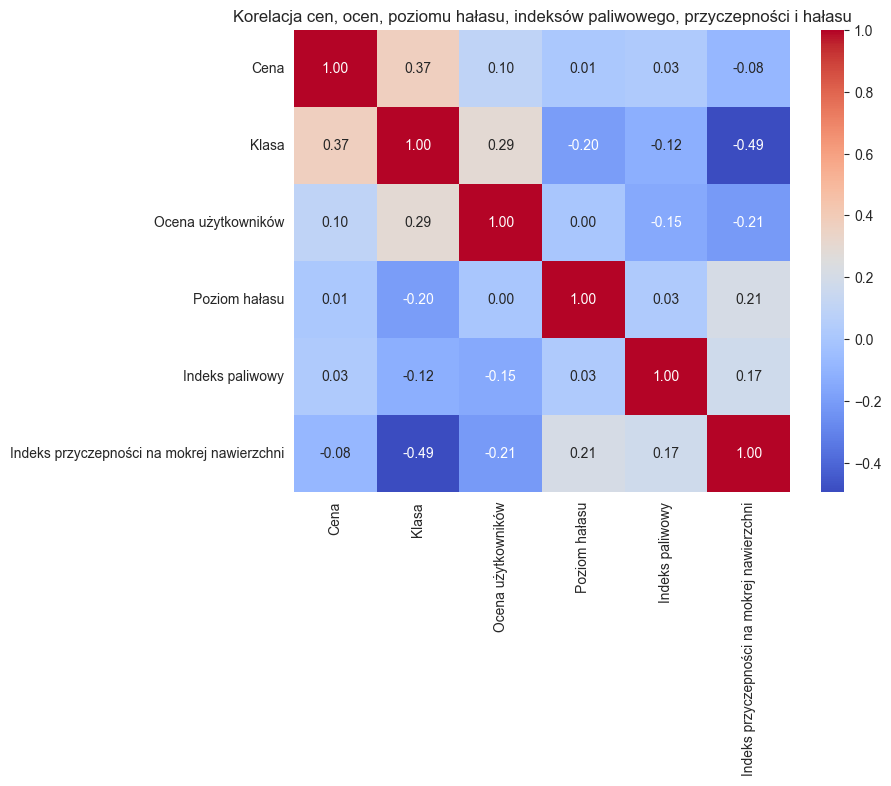

In [90]:
def class_to_int(cls):
    return {'Premium': 3, 'Średnia': 2, 'Ekonomiczna': 1}.get(cls, 0)

def letter_to_int(letter):
    return ord(letter.upper()) - ord('A') + 1

df['fuel_index_int'] = df['fuel_index'].apply(letter_to_int)
df['wet_grip_index_int'] = df['wet_grip_index'].apply(letter_to_int)
df['class_int'] = df['class'].apply(class_to_int)

df_heat_columns = df.rename(columns={
    'price': 'Cena',
    'class_int': 'Klasa',
    'user_rating': 'Ocena użytkowników',
    'noise_level': 'Poziom hałasu',
    'fuel_index_int': 'Indeks paliwowy',
    'wet_grip_index_int': 'Indeks przyczepności na mokrej nawierzchni'
})
correlation = df_heat_columns[['Cena', 'Klasa', 'Ocena użytkowników', 'Poziom hałasu', 
                          'Indeks paliwowy', 'Indeks przyczepności na mokrej nawierzchni']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelacja cen, ocen, poziomu hałasu, indeksów paliwowego, przyczepności i hałasu")
plt.show()

### 4.4. 15 najliczniejszych marek opon w zbiorze danych

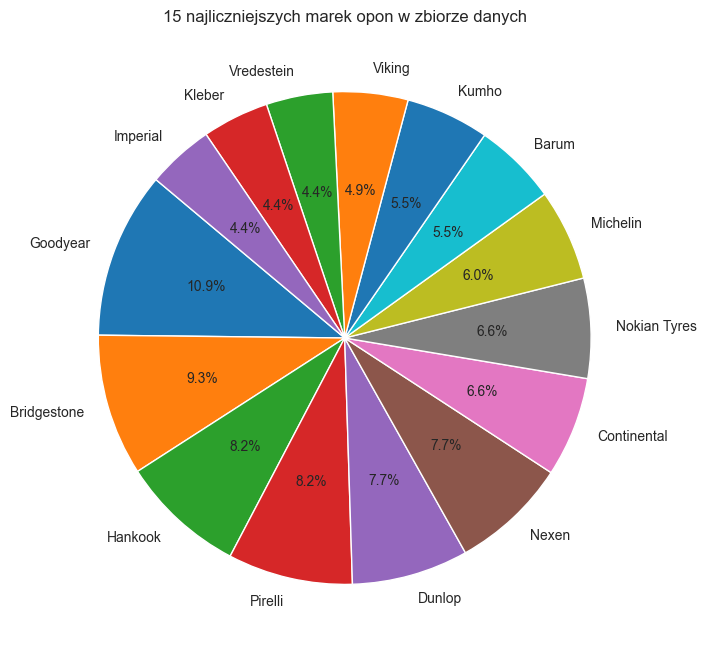

In [91]:
import matplotlib.pyplot as plt

top_15_brands = df['brand'].value_counts().nlargest(15)

plt.figure(figsize=(8, 8))
colors = plt.cm.tab10.colors  # Paleta 10 różnych kolorów
plt.pie(top_15_brands, labels=top_15_brands.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('15 najliczniejszych marek opon w zbiorze danych')
plt.show()


# 5. Porównanie i wnioski

## Kluczowe różnice między sklepami
### Cena:
- Średnia cena opon w Sklepie Opon jest nieco wyższa w porównaniu do Oponeo.
- W przypadku tych samych modeli opon, Oponeo oferuje niższe ceny, co czyni go bardziej opłacalną opcją dla klientów dbających o budżet.
### Cechy opon:
- Sklep Opon ma większy udział opon premium 
- Oponeo ma bardziej zrównoważoną ofertę opon premium, średniej klasy i ekonomicznych.
### Różnorodność oferty:
- Sklep Opon ma większy wybór wysokiej klasy marek i modeli.
- Oponeo zapewnia szerszą gamę opcji w różnych przedziałach cenowych, zaspokajając potrzeby szerszego grona odbiorców.
### Oceny użytkowników:
- Dla tych samych modeli opon, oceny użytkowników są wyższe w Oponeo w porównaniu do Sklep Opon.
- Sugeruje to, że klienci są bardziej zadowoleni z zakupów w Oponeo.
### Wnioski i rekomendacje:
- **Najlepszy stosunek jakości do ceny**: Oponeo oferuje lepszy stosunek jakości do ceny.<br>
- **Opcje premium**: Dla klientów poszukujących opon premium z wysokiej klasy funkcjami, Sklep Opon jest lepszą opcją.<br>
- **Ogólna rekomendacja**: W zależności od potrzeb i budżetu klienta, oba sklepy mają swoje mocne strony. Oponeo jest polecany ze względu na opłacalność i różnorodność, podczas gdy Sklep Opon jest idealny dla osób poszukujących opon premium.<br>
